<a href="https://colab.research.google.com/github/tatiana-uehara/SER-347_MODIS_Time_Series_Filtering/blob/master/TimeMetrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span>BDC ANALYSIS - Spatio-tempoal Metrics <img src="http://brazildatacube.org/wp-content/uploads/slider2/datacube-site.png" alt="Brazil Data Cube" style="height:50px;" align="right"></span>
---------------------------------------------------------------
    


In this notebook, we present some functionalities to perform Geographic Object Image Analysis (GEOBIA) with Earth Observation Data Cubes produced by the <strong>[Brazil Data Cube (BDC) project](http://brazildatacube.org/)</strong> using the <strong>[STMETRICS](https://pypi.org/project/stmetrics/)</strong> package.


This notebook was designed to present some functionalities of the **stmetrics** python package. It provides the state-of-the-art features extraction methods for Satellite Image Time Series (SITS) that can be used for remote sensing time-series image classification and analysis.

Produce reliable land use and land cover maps to support the deployment and operation of public policies is a necessity, especially when environmental management and economic development are considered. To increase the accuracy of these maps, satellite image time-series have been used, as they allow the understanding of land cover dynamics through the time.


## Getting started

Our first step is to install the stmetrics. To do this you can easily run 

`!pip install stmetrics` 

Here, we will use a development version of the package that can do new tricks.

In [ ]:
!pip install git+https://github.com/andersonreisoares/stmetrics@spatial --upgrade

  Cloning https://github.com/andersonreisoares/stmetrics (to revision spatial) to /tmp/pip-req-build-od8nqzok
  Running command git clone -q https://github.com/andersonreisoares/stmetrics /tmp/pip-req-build-od8nqzok
  Running command git checkout -b spatial --track origin/spatial
  Switched to a new branch 'spatial'
  Branch 'spatial' set up to track remote branch 'spatial' from 'origin'.
  Created wheel for stmetrics: filename=stmetrics-0.1.4.5-cp36-none-any.whl size=23896 sha256=3ef0c23d252ff9ff98e4dedf7096165de6d410e4022a3f5f9d94af90c57a98ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-dapi2lpp/wheels/2b/43/3a/06dad7770f99e241f828655cca2bfbea9c1e48e57ef01c9b1e
Successfully built stmetrics
  Found existing installation: stmetrics 0.1.4.5
    Uninstalling stmetrics-0.1.4.5:
      Successfully uninstalled stmetrics-0.1.4.5


In [ ]:
#import modules
import numpy
import pandas
import rasterio
import stmetrics
import multiprocessing as mp
import matplotlib.pyplot as plt

#This is just to remove some annoying possible warnings
import warnings
warnings.filterwarnings('ignore')

## Import test image

You can get the image on this repository: https://github.com/tkorting/remote-sensing-images/blob/master/evi_corte.tif (Thanks Thales!)


Our test image is a small crop from a landsat-8 time series with 12 observations. Let's use rasterio package to use it. 


---


Hint: the **stmetrics** package uses *numpy*, *rasterio* and *geopandas* in most of its functions. Use help or check the documentation to undestand it better https://stmetrics.readthedocs.io/en/latest/.



In [ ]:
#Import files
filename = '/content/evi_corte.tif'
try:
  ds = rasterio.open(filename)
except:
  print("error loading", filename)

Now lets plot the image and get some info about its dimensions.

12 observations 234 rows 374 columns


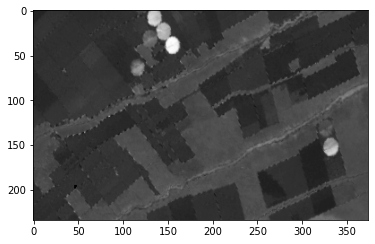

In [ ]:
# recupera o array da série temporal, uma matriz numpy (#observações, linhas, colunas)
img = ds.read()
img = img[:,10:-5,10:-10]
observations = img.shape[0]
rows = img.shape[1]
columns = img.shape[2]
print(observations, 'observations', rows, 'rows', columns, 'columns')

plt.imshow(img[0,:,:], cmap = 'gray')

Now lets select some sample points to be used in our examples.

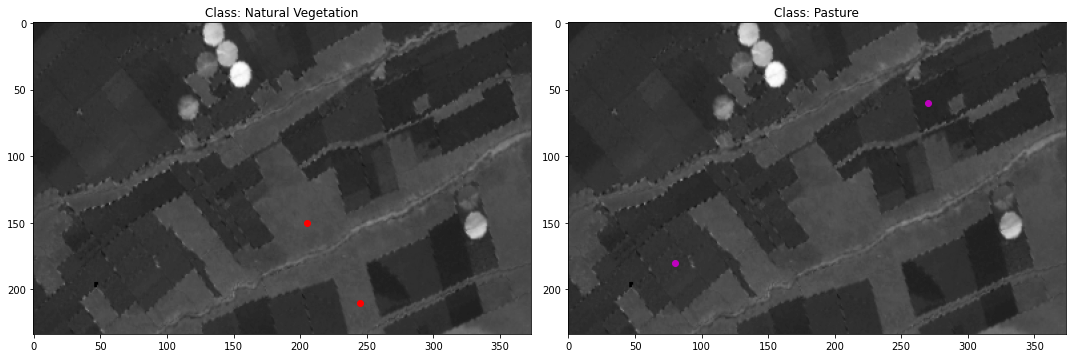

In [ ]:
fig= plt.figure(figsize=(15, 15))  # width, height in inches
sub = fig.add_subplot(1, 2, 1)
sub.imshow(img[0,:,:], cmap = 'gray')
plt.scatter(205,150,color='r')
plt.scatter(245,210,color='r')
plt.title('Class: Natural Vegetation')
sub = fig.add_subplot(1, 2, 2)
sub.imshow(img[0,:,:], cmap = 'gray')
plt.scatter(80,180,color='m')
plt.scatter(270,60,color='m')
plt.title('Class: Pasture')
plt.tight_layout()

# Time Series extraction

Now let's use our "samples" to extract some time series profiles.

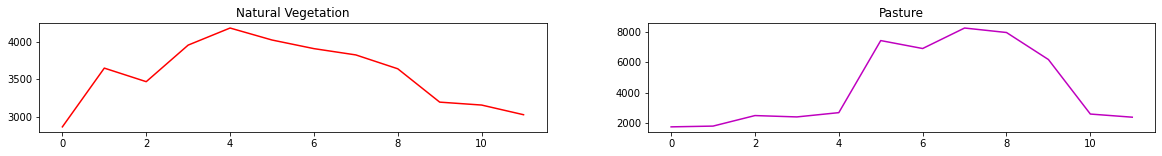

In [ ]:
fn = img[:,150,205] # formação natural
pasto = img[:,180,80] #pasto

fig, ax = plt.subplots(1,2, figsize=(20,2))
#sub = ax.add_subplot(1, 2, 1)
ax[0].plot(fn,color = 'r')
ax[0].title.set_text('Natural Vegetation')
#sub = ax.add_subplot(1, 2, 2)
ax[1].plot(pasto, color = 'm')
ax[1].title.set_text('Pasture')

## Polar plot

The stmetrics is currently composed by 4 modules:

*   Metrics - With some functions to compute the all metrics available
*   Basics  - That has the implementation of the basics metrics
*   Polar   - That has the implementation of the polar metrics proposed by Körting (2013).
*   Fractal - That has the implementatio of fractal metrics that are currently under assessment.


The polar approach proposed by Körting (2013) convert the time series to a polar coordinate system. This way we can plot the series in this space just to look at it and get some insights about the time series. For this, we can use the funtion *polar_plot*. 

The plot as you will see is composed by the series over four quadrants. The idea here is observe a stronger response over a specific period. Imagine that your time series encompass a year of observations, this way each quadrant represents 3 months.


![Polar plot representation.](https://drive.google.com/uc?export=view&id=1IFFXSFtNNZJ4L_ihfnRgBTD6jRf4puoD)


> Reference: Körting, Thales & Câmara, Gilberto & Fonseca, Leila. (2013).Land Cover Detection Using Temporal Features Based On Polar Representation.









Natural Vegetation


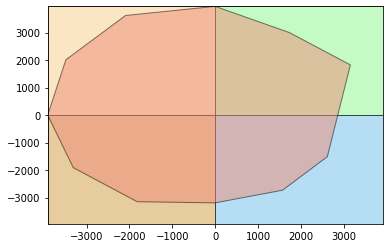

Pasture


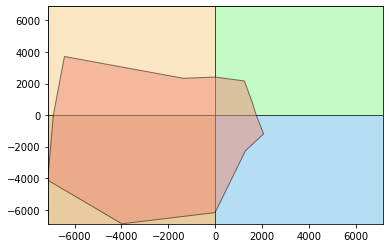

In [ ]:
#Plotting our time series samples
#Natural Vegetation
print('Natural Vegetation')
stmetrics.polar.polar_plot(fn)

print('Pasture')
#Pasture
stmetrics.polar.polar_plot(pasto)

# Metrics computation

The stmetrics has two functions to compute the metrics. The *get_metrics* function was designed to be used for compute the metrics of one time series. Along with the metrics, using the function you can also see the polar plot. Just remember, one series each time.

The *sits2metrics* function was developed to compute the metrics over images, as the name states. For this function we use multiprocessing package to improve perfomance. Don't worry if it is using the whole campacity of your system, it was designed to do it. 

> In future versions you will be able to set the number of cores that you want to use.

---
Hint: This process may take sometime deppending on your system.


In [ ]:
im_metrics = stmetrics.metrics.sits2metrics(ds)

## Image Metrics

The output of *get_metrics* and sits2metrics follows the same order:

`["Mean", "Max", "Min", "Std", "Sum","Amplitude","First_slope","Area","Area_s1","Area_s2","Area_s3","Area_s4","Circle","Gyration","Polar_balance","Angle", "DFA","Hurst","Katz"]`

Keep it in mind when you use it. We are studying a way to show it in the output. Bellow you will see the results of each metric. Try to analyse the output of the metric with the "samples" that we have.

Don't worry if some metric is too noise or you don't see a clear pattern, some features are not always representative.

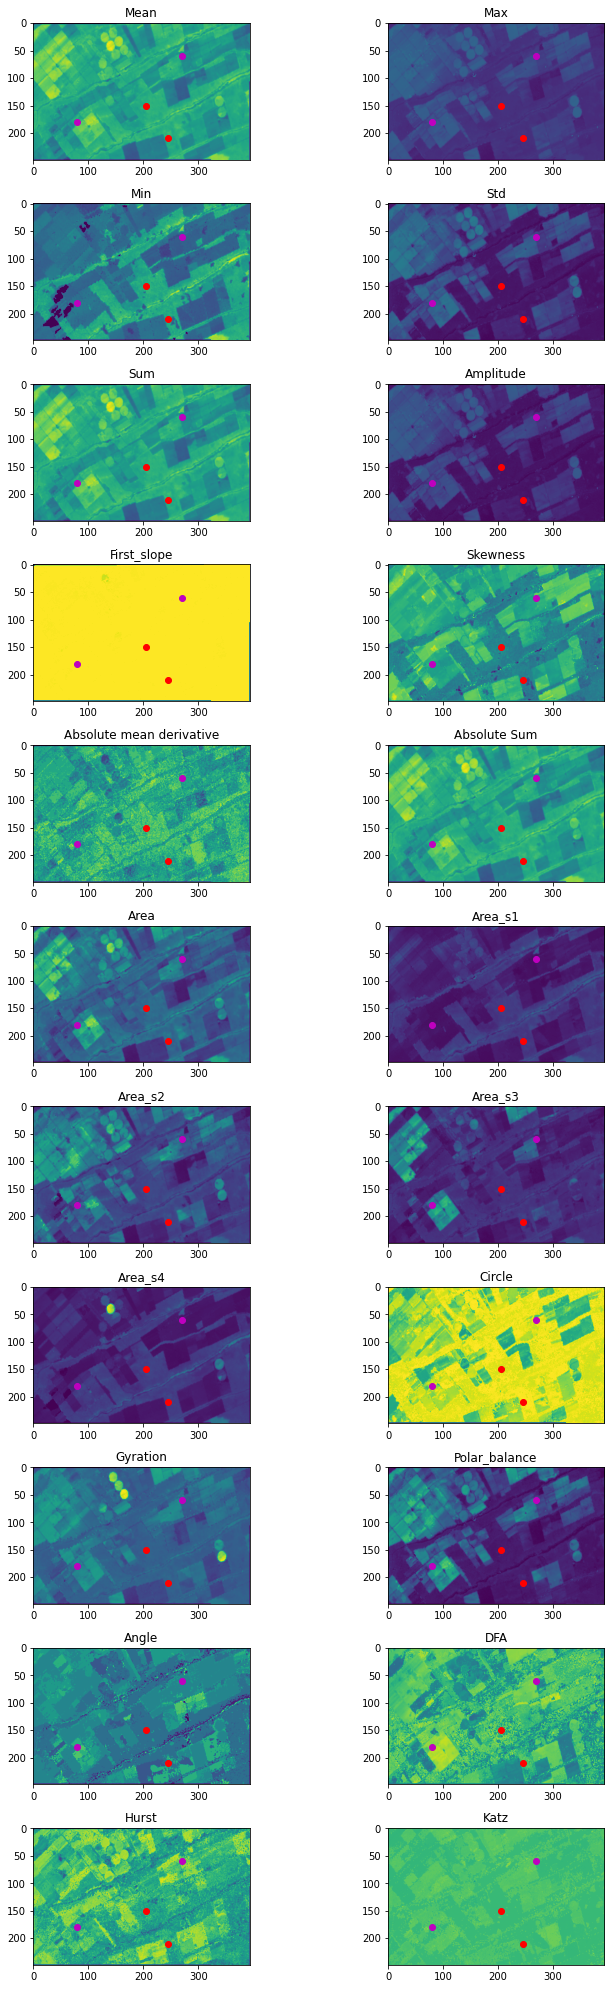

In [ ]:
header=["Mean", "Max", "Min", "Std", "Sum","Amplitude","First_slope","Skewness","Absolute mean derivative","Absolute Sum","Area","Area_s1","Area_s2","Area_s3","Area_s4","Circle","Gyration","Polar_balance","Angle", "DFA","Hurst","Katz"]

plt.figure(1,figsize=(10,30))
for b,n in zip(range(1, im_metrics.shape[0]+1),header):
    plt.subplot(12,2,b,)
    plt.imshow(im_metrics[b-1,:,:])
    plt.scatter(205,150,color='r')
    plt.scatter(245,210,color='r')
    plt.scatter(80,180,color='m')
    plt.scatter(270,60,color='m')
    plt.tight_layout()
    plt.title(n)

plt.show()

# That's all!

Soon we will have more examples and usages to perform classifications. Moreover, soon segmentation examples will also be available. 

Keep watching our repo on github https://github.com/brazil-data-cube/stmetrics or https://github.com/andersonreisoares/stmetrics and our documentation https://stmetrics.readthedocs.io/en/latest/! 

If you find any problems in the package, please, submit an issue on github or send an e-mail to anderson.soares@inpe.br. 

**Thanks for checking!**